In [1]:
# standard libraries
import torch as torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# vision libraries
import cv2 

# nlp libraries
from textblob import TextBlob
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from wordcloud import WordCloud, ImageColorGenerator
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

### Structure
- dataset examples <br>
- text exploratory data analysis <br>
- images exploratory data analysis <br>

### Dataset statistics

In [2]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)
dataset_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [3]:
# statistics
total_train_img = len(dataset_df['label'].values)
pos_train_img = np.sum(dataset_df['label'].values)

print('%Racist: '+ str(np.round(100.* pos_train_img/total_train_img, 0)))
print('%Non-Racist: '+ str(np.round(100.- 100.*pos_train_img/total_train_img, 0)))

%Racist: 36.0
%Non-Racist: 64.0


## Text EDA

In [4]:
# sentence length (in #words)
# https://textblob.readthedocs.io/en/dev/
sentence_length = np.zeros(len(dataset_df))

for i in range(len(dataset_df)):
    text_string = dataset_df['text'].values[i]
    sentence_length[i] = len(text_string.split()) 
    
print('Mean sentence length: '+ str(np.round(np.mean(sentence_length), 2)))
print('Max sentence length: '+ str(np.round(np.max(sentence_length), 2)))
print('Max sentence length: '+ str(np.round(np.min(sentence_length), 2)))

Mean sentence length: 11.74
Max sentence length: 70.0
Max sentence length: 1.0


In [5]:
# remove stop words and punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")

words = dataset_df['text']
allwords = []

for wordlist in words:
    # remove stop words (the, a, and, ...)
    text_tokens = word_tokenize(wordlist)
    
    # stopwords
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    # punctuation (attention: does also filter out things like "'aint'")
    tokens_without_sw = [word for word in tokens_without_sw if word.isalpha()]
    
    allwords.append((" ").join(tokens_without_sw))

dataset_df['text_sw_str'] = allwords # strings
dataset_df['text_sw'] = [l.split() for l in dataset_df['text_sw_str']] # splitted into words

In [6]:
print(dataset_df['text_sw_str'])

print(dataset_df['text_sw'])

0                                 character color matters
1                            afraid love everyone like ex
2                                            putting bows
3       love everything everybody except squirrels hat...
4       everybody loves chocolate chip cookies even hi...
                              ...                        
8495                          nobody wants hang auschwitz
8496    god grants child years marriage israel bombs y...
8497    gays social media equality body positivity lov...
8498    bad day could siamese twin attached gay brothe...
8499    hate muslims religion seriously pathetic weakl...
Name: text_sw_str, Length: 8500, dtype: object
0                             [character, color, matters]
1                      [afraid, love, everyone, like, ex]
2                                         [putting, bows]
3       [love, everything, everybody, except, squirrel...
4       [everybody, loves, chocolate, chip, cookies, e...
                         

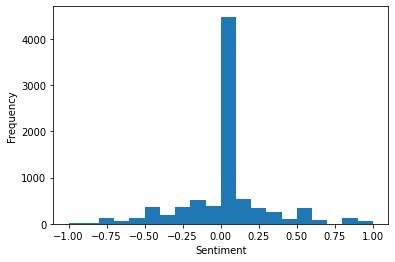

In [7]:
# plot sentiment polarity: range [-1, 1] with -1 negative, +1 positive
dataset_df['sentiment'] = dataset_df['text_sw_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
plt.figure()
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(dataset_df['sentiment'], bins=20)
plt.show()

<>:4: DeprecationWarning: invalid escape sequence \q
<>:4: DeprecationWarning: invalid escape sequence \q
<>:4: DeprecationWarning: invalid escape sequence \q
<ipython-input-8-000064c3bb73>:4: DeprecationWarning: invalid escape sequence \q
  plt.xlabel('Non-Racist $\quad$ - $\quad$ Racist')


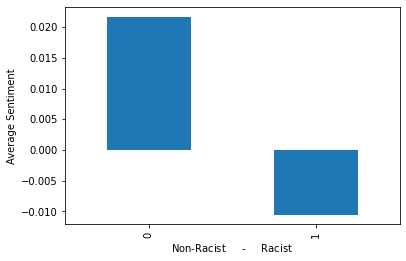

In [8]:
# plot sentiment versus racist(1) and non-racist(0)
plt.figure()
dataset_df.groupby('label')['sentiment'].mean().plot(kind='bar')
plt.xlabel('Non-Racist $\quad$ - $\quad$ Racist')
plt.ylabel('Average Sentiment')
plt.show()

In [9]:
words = dataset_df['text_sw']
allwords = []

for wordlist in words:
    allwords += wordlist

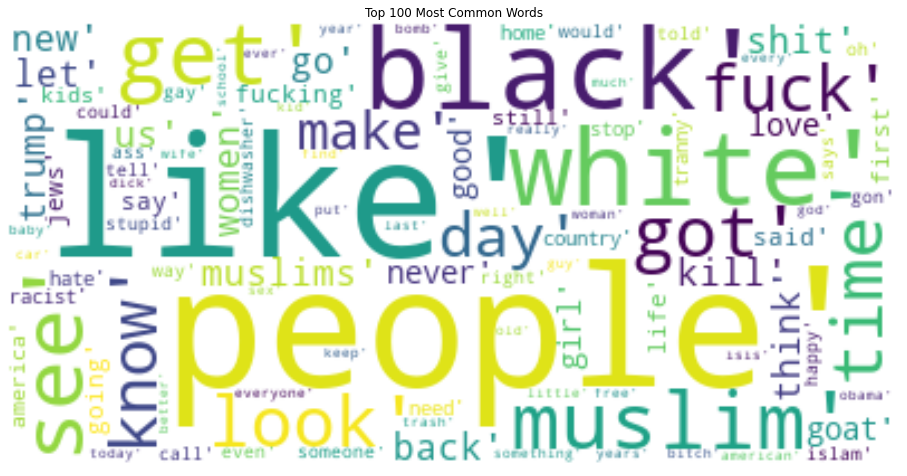

[('like', 587), ('people', 566), ('black', 386), ('white', 363), ('get', 340), ('see', 247), ('muslim', 239), ('got', 225), ('look', 216), ('time', 211), ('fuck', 211), ('know', 202), ('day', 197), ('make', 196), ('muslims', 195), ('shit', 192), ('go', 191), ('new', 163), ('kill', 162), ('us', 159), ('women', 155), ('back', 154), ('trump', 151), ('let', 146), ('think', 145)]


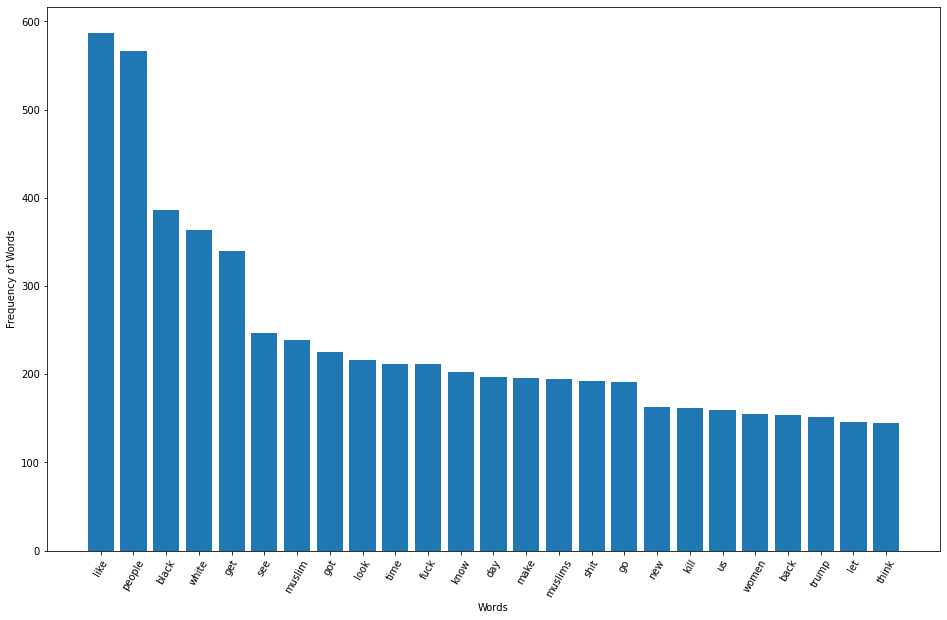

In [10]:
# study the most common words (removed stop words)    
mostcommon = FreqDist(allwords).most_common(100)

wordcloud = WordCloud(background_color='white').generate(str(mostcommon))

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words')
plt.show()

#
mostcommon_small = FreqDist(allwords).most_common(25)
print(mostcommon_small)
x, y = zip(*mostcommon_small)

plt.figure(figsize=(16,10))
plt.bar(x,y)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)
plt.show()

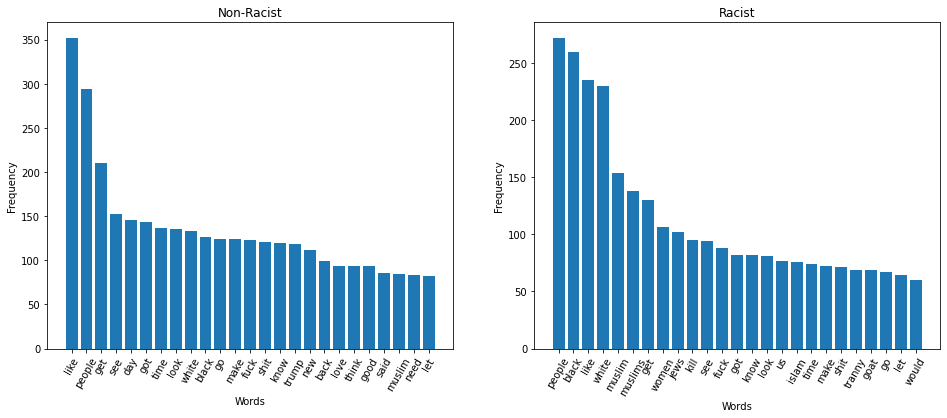

In [11]:
from collections import Counter
group_by = dataset_df.groupby('label')['text_sw_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

# non racist (0)
group_nonracist = group_by.iloc[0]
words_nonracist = list(zip(*group_nonracist))[0]
freq_nonracist = list(zip(*group_nonracist))[1]

# racist (1)
group_racist = group_by.iloc[1]
words_racist = list(zip(*group_racist))[0]
freq_racist = list(zip(*group_racist))[1]

fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
ax[0].bar(words_nonracist, freq_nonracist)
ax[0].set_xticklabels(words_nonracist, rotation=60)
ax[0].set_title('Non-Racist')
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Frequency')

ax[1].bar(words_racist, freq_racist)
ax[1].set_xticklabels(words_racist, rotation=60)
ax[1].set_title('Racist')
ax[1].set_xlabel('Words')
ax[1].set_ylabel('Frequency')

plt.show()

In [12]:
# aus diesen diagrammen werde ich noch nicht schlau

# count vectorisation: tokens -> features and provides count of occurence
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=1000) # remove words in more than 90% of memes and less than 25 memes
tf = tf_vectorizer.fit_transform(dataset_df['text_sw_str'].values.astype('U'))

# latent dirichlet allocation model
lda_model = LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=100, random_state=0).fit(tf)

# interactive LDA visualisation
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  22.704896
3       51.163364 -159.968018       2        1  20.771707
1      -73.144554   21.523815       3        1  20.669138
2      -66.410133 -110.606438       4        1  19.773974
0       54.417324   12.443444       5        1  16.080285, topic_info=       Term        Freq       Total Category  logprob  loglift
248  people  555.000000  555.000000  Default  30.0000  30.0000
112     get  328.000000  328.000000  Default  29.0000  29.0000
32    black  385.000000  385.000000  Default  28.0000  28.0000
222  muslim  239.000000  239.000000  Default  27.0000  27.0000
356   white  363.000000  363.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
190    live   40.674742   41.457595   Topic5  -4.5218   1.8085
277    said  100.595799  126.589570   Topic5  -3.6163   1.5977
314    talk   44.793425   49.578579   Topic5  -4.4254   1.7261
356   white   99.265456  363.356191   Topic5  -3.6296   0.5300
188    like  107.165544  579.690475   Topic5  -3.5531   0.1395

[202 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.993136     allah
5         2  0.991965    always
6         3  0.995861   america
7         2  0.983791  american
9         1  0.979905   another
...     ...       ...       ...
362       3  0.979440     world
363       3  0.995625     would
364       4  0.989875     wrong
366       2  0.989297      year
367       5  0.988823     years

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

## Image EDA

In [13]:
# image dimensions
x_dim = np.zeros(len(dataset_df))
y_dim = np.zeros(len(dataset_df))

for i in range(len(dataset_df)):
    img_id = dataset_df['id'].values[i]

    # catch 0 trailing numbers
    if img_id < 1e4:
        img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
    y_dim[i], x_dim[i] = img.shape

print('Horizontal dimensions')
print('mean: '+ str(np.round(np.mean(x_dim), 2)))
print('max: '+ str(np.round(np.max(x_dim), 2)))
print('min: '+ str(np.round(np.min(x_dim), 2)))
print('')

print('Vertical dimensions')
print('mean: '+ str(np.round(np.mean(y_dim), 2)))
print('max: '+ str(np.round(np.max(y_dim), 2)))
print('min: '+ str(np.round(np.min(y_dim), 2)))
print('')

print('Aspect Ratio')
print('mean: '+ str(np.round(np.mean(x_dim/ y_dim), 2)))
print('max: '+ str(np.round(np.max(x_dim/ y_dim), 2)))
print('min: '+ str(np.round(np.min(x_dim/ y_dim), 2)))

Horizontal dimensions
mean: 597.65
max: 825.0
min: 94.0

Vertical dimensions
mean: 523.6
max: 823.0
min: 94.0

Aspect Ratio
mean: 1.21
max: 5.85
min: 0.19


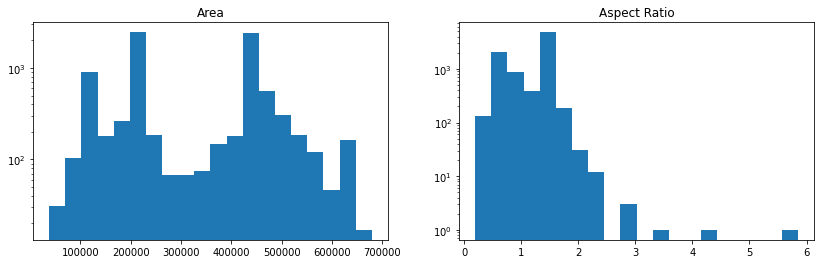

In [14]:
area = x_dim* y_dim
aspect_ratio = x_dim/ y_dim

fig, ax = plt.subplots(figsize=(14, 4), ncols=2, nrows=1)
ax[0].hist(area, bins=20)
ax[0].set_yscale('log')
ax[0].set_title('Area')
ax[1].hist(aspect_ratio, bins=20)
ax[1].set_yscale('log')
ax[1].set_title('Aspect Ratio')
plt.show()

In [15]:
%%javascript
// avoid scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

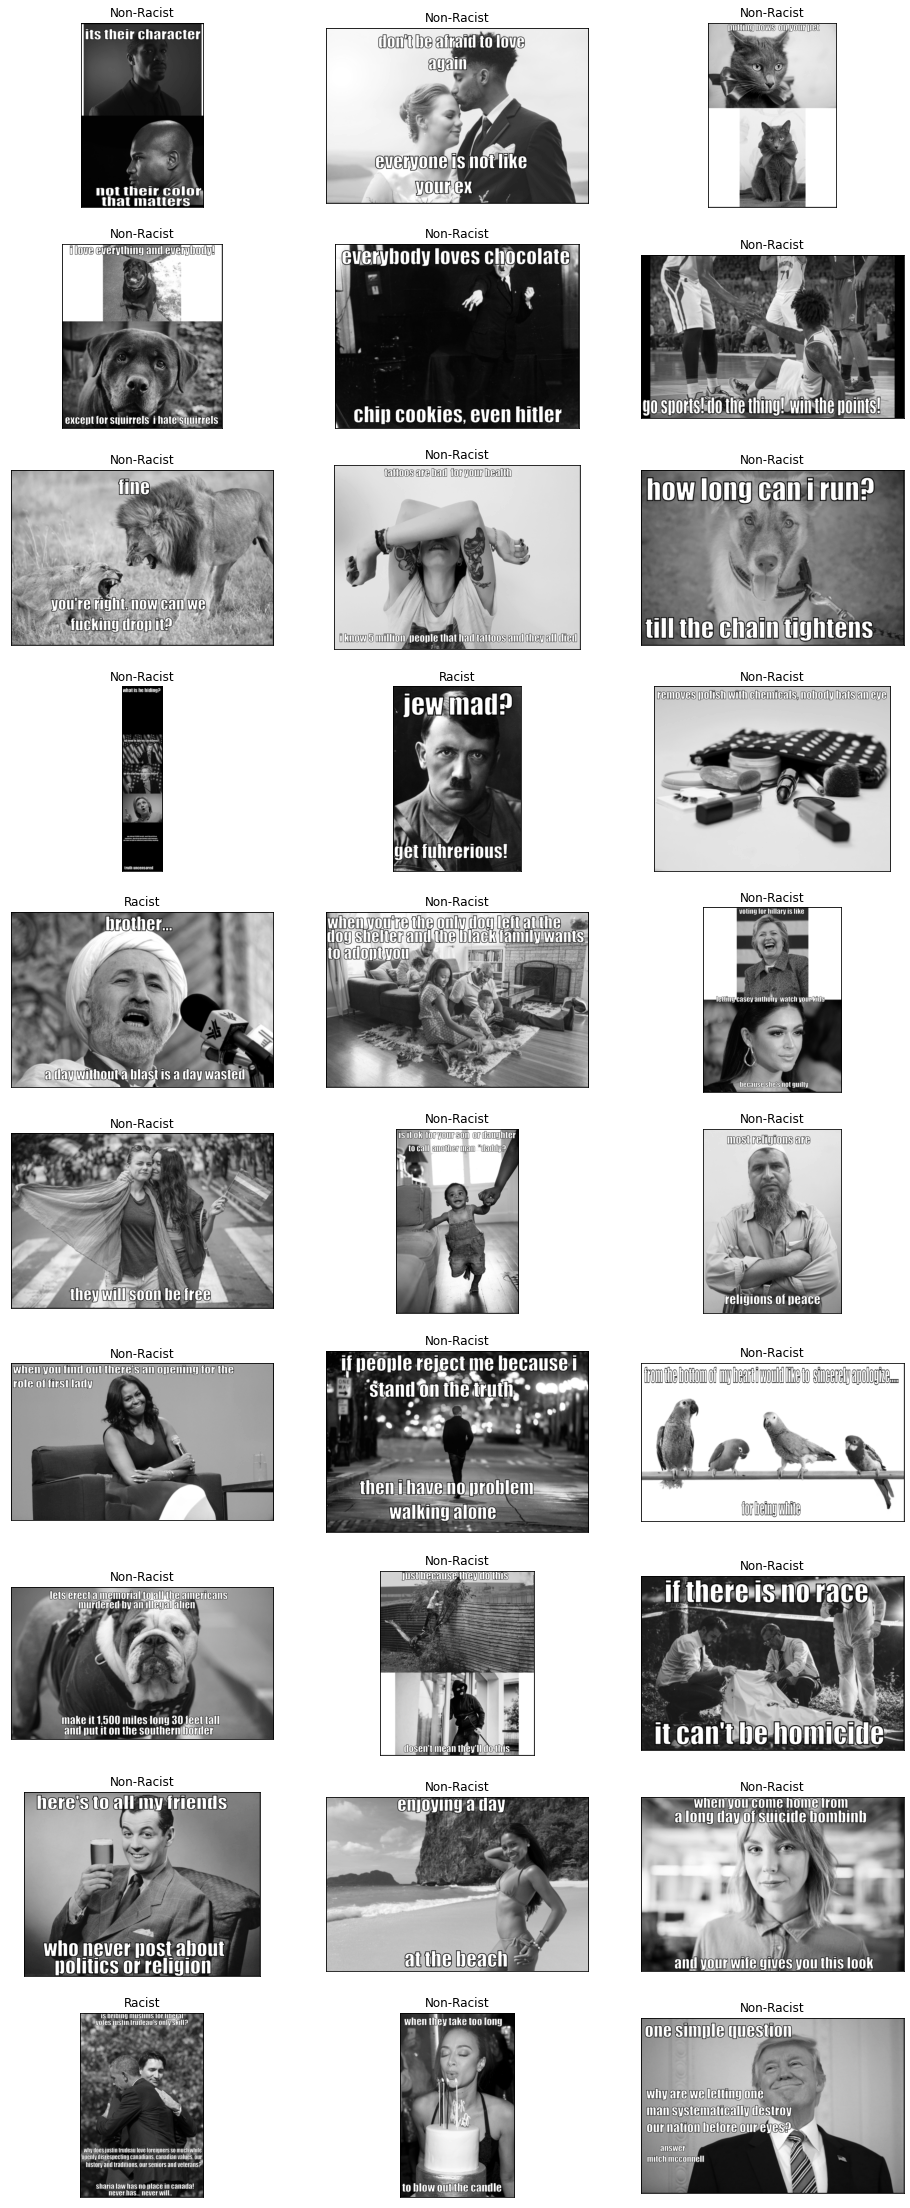

In [16]:
# plot a few images together with labels
nx = 3
ny = 10

fig, ax = plt.subplots(figsize=(16, ny*4), nrows=ny, ncols=nx)
for i in range(ny):
    for j in range(nx):
        img_id = dataset_df['id'].values[i*nx+ j]
        
        # catch trailing 0
        if img_id < 1e4:
            img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
        # plot and remove axes
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title('Racist' if dataset_df['label'].values[i*nx+ j] else 'Non-Racist')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        
plt.show()